In [29]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import re
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jackb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
dataset = pd.read_csv(r'Data\amazon_alexa.tsv', delimiter='\t',quoting=3)   
print(dataset)


      rating       date         variation  \
0          5  31-Jul-18  Charcoal Fabric    
1          5  31-Jul-18  Charcoal Fabric    
2          4  31-Jul-18    Walnut Finish    
3          5  31-Jul-18  Charcoal Fabric    
4          5  31-Jul-18  Charcoal Fabric    
...      ...        ...               ...   
3145       5  30-Jul-18        Black  Dot   
3146       5  30-Jul-18        Black  Dot   
3147       5  30-Jul-18        Black  Dot   
3148       5  30-Jul-18        White  Dot   
3149       4  29-Jul-18        Black  Dot   

                                       verified_reviews  feedback  
0                                         Love my Echo!         1  
1                                             Loved it!         1  
2     "Sometimes while playing a game, you can answe...         1  
3     "I have had a lot of fun with this thing. My 4...         1  
4                                                 Music         1  
...                                                

In [5]:
dataset.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
dataset[dataset['verified_reviews'].isna() == True]


,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [7]:
dataset.dropna(inplace=True)

In [8]:
# Pre processing of data
corpus = []
stemmer = PorterStemmer()
for i in range(0,dataset.shape[0]):
    review = re.sub('[^a-zA-Z]','',dataset.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [9]:
cv = CountVectorizer(max_features=2500)

x = cv.fit_transform(corpus).toarray()
y = dataset['feedback'].values

In [10]:
# Saving Count Vector
pickle.dump(cv, open(r'Models\Count_Vectorization.pkl','wb'))

In [11]:
print(f"X Shape - {x.shape}")
print(f"Y Shape - {y.shape}")

X Shape - (3149, 2233)
Y Shape - (3149,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15)
print(f"X Train - {X_train.shape}")
print(f"Y Train - {y_train.shape}")
print(f"X Test - {X_test.shape}")
print(f"Y Test - {y_test.shape}")

X Train - (2204, 2233)
Y Train - (2204,)
X Test - (945, 2233)
Y Test - (945,)


In [13]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [14]:
pickle.dump(scaler, open(r'Models\MinMax_Scaler.pkl','wb'))

In [15]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [23]:

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9954627949183303
Testing Accuracy : 0.9375661375661376


In [26]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9192377495462795
Testing Accuracy : 0.9174603174603174


In [28]:
y_preds = model_xgb.predict(X_test)

In [30]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[  0  78]
 [  0 867]]


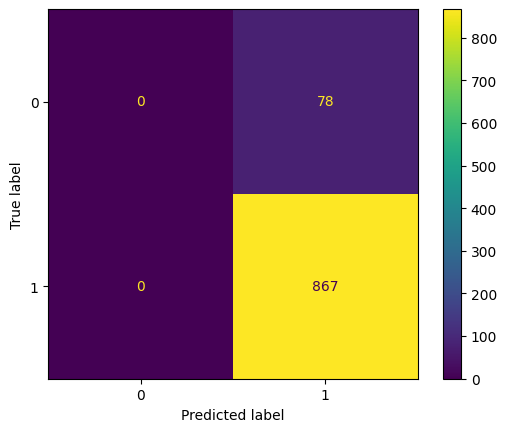

In [31]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [32]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))